In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import gurobipy as gp
from gurobipy import GRB
import cvxpy as cp

import random
from itertools import chain, combinations, tee
import time

# Load Input Data:

In [2]:
vot_pdf = np.genfromtxt('../original_code/VOT_distr.csv', delimiter=',')[1:]
vots = []
vot_p = []
for row in vot_pdf:
    vots.append(row[0])
    vot_p.append(row[1])
print(vot_p)
print()
vot_p=vot_p/np.sum(vot_p)
print(vot_p)

[0.01, 0.02, 0.01, 0.02, 0.02, 0.02, 0.02, 0.04, 0.02, 0.07, 0.02, 0.07, 0.16, 0.13, 0.05, 0.25, 0.03, 0.05]

[0.00990099 0.01980198 0.00990099 0.01980198 0.01980198 0.01980198
 0.01980198 0.03960396 0.01980198 0.06930693 0.01980198 0.06930693
 0.15841584 0.12871287 0.04950495 0.24752475 0.02970297 0.04950495]


In [3]:
# vot_p

start_time = time.time()
print("Hi!")
end_time = time.time()
end_time - start_time

Hi!


0.0001087188720703125

# Travel time functions:

In [4]:
###### BPR Parameters ###### 
bpr_true_capacity = 66
bpr_true_fftt = 60*22/67
bpr_true_alpha = 0.2

def true_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, alpha = bpr_true_alpha):
    """
    Find the (exact) travel time on an edge given an edge flow
    """

    return fftt * (1+alpha*(flow_val/capacity)**6)

###### Approximation Parameters ###### 
const_multiplier = 1
cap_thresh_multiplier = 0.7835
apx_slope = 0.314

def apx_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, 
                a = const_multiplier, cap_thresh = cap_thresh_multiplier, b = apx_slope):
    """
    Find the (approximate) travel time on an edge given an edge flow
    """
    
    if flow_val <= cap_thresh*capacity:
        return a*fftt
    else:
        return a*fftt + b*(flow_val - cap_thresh*capacity)

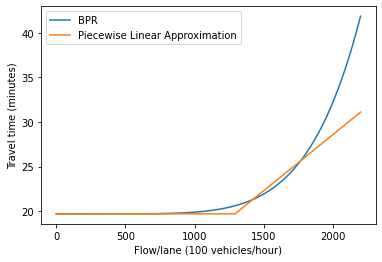

In [5]:
###### Check plots of BPR and approximation ###### 
multiplier = 100/4 # converts from 100 vehicles/hour --> vehicle/hour per lane

x =  np.linspace(0,int(np.round(88*multiplier,0)),int(np.round(89*2*multiplier,0)))
y = [true_bpr_cost(i, capacity = bpr_true_capacity*multiplier) for i in x]

plt.plot(x, y,label='BPR')

y_apx = [apx_bpr_cost(i,capacity = bpr_true_capacity*multiplier, b = apx_slope/multiplier) for i in x]

plt.plot(x, y_apx,label='Piecewise Linear Approximation')
plt.xlabel("Flow/lane (100 vehicles/hour)")
plt.ylabel("Travel time (minutes)")
plt.legend(loc='upper left')

# Generate Demand Profile:

In [6]:
###### Specify parameters for problem ###### 
T = 5 # Time Horizon
tau_arr = 20*np.linspace(0, 1, 21)[0:] # Toll discretization
print('Tau:\n {}'.format(tau_arr))
print()

B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 
print('B:\n {}'.format(B_arr))
print()

num_total = 8000 # number of users
num_eligible =int( num_total*.17) # number of eligible users
num_ineligible = num_total-num_eligible # number of ineligible users

###### VoT information ###### 
vot_all = np.sort(np.round(np.random.choice(vots, size = num_total, p=vot_p),2)/60) # generate baseline VoT for all users
vot_all_days = np.empty(shape=(num_total,T)) 
count=0
for v in vot_all:
    if count < num_eligible:
        vot_all_days[count,:]=[v for t in range(T)] # VoT of eligible users does not vary over time periods
    else:
        vot_all_days[count,:]=list((1+0.25*(np.random.random_sample(size=T)-0.5))*v) # VoT of ineligible users varies over time periods
    count+=1
    
vot_eligible = vot_all_days[:num_eligible,:]
vot_ineligible= vot_all_days[num_eligible:,:]

print('Eligible vot range:\n {} ({} $/hr), {} ({} $/hr)'.format(np.min(vot_eligible),60*np.min(np.round(vot_eligible,2)),np.max(np.round(vot_eligible,2)),60*np.max(np.round(vot_eligible,2))))
print()
print('Ineligible vot range:\n {}({} $/hr), {} ({} $/hr)'.format(np.min(np.round(vot_ineligible,2)),60*np.min(np.round(vot_ineligible,2)),np.max(np.round(vot_ineligible,2)),60*np.max(np.round(vot_ineligible,2))))
print()
print('Mean vot:\n {} $/hr; median: {} $/hr'.format(60*np.round(np.mean(vot_all_days),2),60*np.round(np.median(vot_all_days),2)))

Tau:
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]

B:
 [ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80. 85.
 90.]

Eligible vot range:
 0.02 (1.2 $/hr), 0.24 (14.399999999999999 $/hr)

Ineligible vot range:
 0.21(12.6 $/hr), 2.7 (162.0 $/hr)

Mean vot:
 45.0 $/hr; median: 37.2 $/hr


Text(0, 0.5, '% of population')

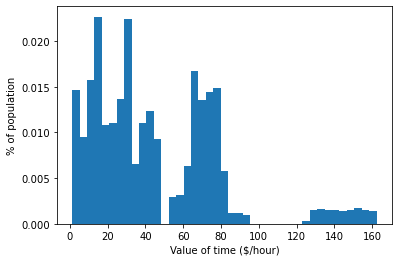

In [7]:
###### Check VoT distribution ###### 
plt.hist(vot_all_days.flatten()*60,bins=41,density=True)
plt.xlabel("Value of time ($/hour)")
plt.ylabel("% of population")

# Optimization Solver:

In [97]:
def OptPL_budget(toll, B, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible, 
            vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
              fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity, c_2 = bpr_true_capacity, 
             a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope, b_2 = apx_slope):
    """
    Function to solve convex optimization problem given a particular toll and budget value
    """
    
    # Initialize model
    m1 = gp.Model()
    # Add variables to model
#     users_in = m1.addVars(num_ineligible, 3, T, name = 'ineligible_val', lb = 0.0, ub = 2.0)
#     edge_flows = m1.addVars(2, T, name = 'edge_flows', lb = 0.0, ub = num_ineligible * 2.0)
#     users_el = m1.addVars(3, T, name = 'eligible_allocation', lb = 0.0, ub = 2.0)
    # Add variables for piecewise affine approximation
#     eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = 0.0, ub = num_ineligible * 2.0)
    
#     # Add variables for piecewise affine approximation
#     eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = 0.0, ub = num_ineligible * 2.0)
    users_in = m1.addVars(num_ineligible, 3, T, name = 'ineligible_val', lb = -10000.0, ub = 10000.0)
    edge_flows = m1.addVars(2, T, name = 'edge_flows', lb = -10000.0, ub = 10000.0)
    users_el = m1.addVars(3, T, name = 'eligible_allocation', lb = -10000.0, ub = 10000.0)
    eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = -10000.0, ub = 10000.0)   

    ## Add constraints to Model 
    
    # Total edge flow, express lane:
    m1.addConstrs((edge_flows[0, t] == sum(users_in[i, 0, t] for i in range(num_ineligible)) + \
                  users_el[0, t] + sum(users_in[i, 1, t] for i in range(num_ineligible)) + \
                  users_el[1, t] for t in range(T)))
    # Total edge flow, general purpose lane:
    m1.addConstrs((edge_flows[1, t] == sum(users_in[i, 2, t] for i in range(num_ineligible)) + \
                  users_el[2, t] for t in range(T)))
    
    # Non-negativity of flows, and zero flow for "eligible users in ineligible groups":
    m1.addConstrs((users_in[i, j, t]>=0 for i in range(num_ineligible) for j in range(3) for t in range(T)))
    m1.addConstrs((users_in[i, 0, t]==0 for i in range(num_ineligible) for t in range(T)))
    m1.addConstrs((users_el[j, t]>=0 for j in range(3) for t in range(T)))
    
    # Every eligible and ineligible user is assigned to one of three options: \
    # (express paying, express with credit, non-express)
    m1.addConstrs((sum(users_in[i, j, t] for j in range(3)) == 1 for i in range(num_ineligible) for t in range(T)))
    m1.addConstrs((sum(users_el[j, t] for j in range(3)) == num_eligible for t in range(T)))
    
    # Budget constraint satisfaction:
    if toll != 0:
        m1.addConstr((sum(toll*users_el[0, t] for t in range(T)) <= B * num_eligible))
        
    # Piecewise affine approximation:
    m1.addConstrs((eps_flows[j, t] >= 0 for j in range(2) for t in range(T))) # Must be at least 0
    m1.addConstrs((eps_flows[0, t] >= edge_flows[0, t] - cap_thresh*c_1 for t in range(T))) # Must be at least flow - capacity
    m1.addConstrs((eps_flows[1, t] >= edge_flows[1, t] - cap_thresh*c_2 for t in range(T))) # Must be at least flow - capacity
    
    # Set Objective
    m1.setObjective(sum( a*fftt_1*(edge_flows[0, t]) + b_1*(eps_flows[0, t]**2)/2  
                        + a*fftt_2*(edge_flows[1, t]) + b_2*(eps_flows[1, t]**2)/2 
                        + sum( toll*users_in[i,1,t]/vot_ineligible[i,t] for i in range(num_ineligible)) 
        for t in range(T)), GRB.MINIMIZE)
    
    m1.update()
    
    return m1

In [98]:
def _extract_solution(m, num_ineligible = num_ineligible):
    """
    Get solution from optimization model
    """
    users_in = [v.x for v in m.getVars() if v.VarName.find("ineligible_val") != -1]
    users_el = [v.x for v in m.getVars() if v.VarName.find("eligible_allocation") != -1]
    edge_flows = [v.x for v in m.getVars() if v.VarName.find("edge_flows") != -1]
    eps_flows = [v.x for v in m.getVars() if v.VarName.find("eps_flows") != -1]
    
    users_in = np.reshape(users_in, (num_ineligible, 3, T))
    users_el = np.reshape(users_el, (3, T))
    edge_flows = np.reshape(edge_flows, (2, T))
    eps_flows = np.reshape(eps_flows, (2, T))

    solution = {
        "users_in": users_in,
        "users_el": users_el,
        "edge_flows": edge_flows,
        "eps_flows": eps_flows
    }
    return solution

# Sample Optimization Problem:

## Gurobi:

In [99]:
# Gurobi:

time_1 = time.time()

toll = 1.0
budget = 3.0
demand_multiplier = [25,75]

# num_ineligible_trunc = num_ineligible

# Truncating num_ineligible to enable comparison with CVXPY (which is very, very slow):
# num_ineligible_trunc = 200
# num_ineligible_trunc = int(num_ineligible/3)
num_ineligible_trunc = num_ineligible

print("num_total:", num_total)
print("num_eligible:", num_eligible)
print("num_ineligible:", num_ineligible)
print("toll:", toll)
print("budget:", budget)
print("num_eligible:", num_eligible)
print("num_ineligible_trunc:", num_ineligible_trunc)
print("vot_ineligible:", vot_ineligible)
print("alpha:", bpr_true_alpha)
print("fftt_1:", bpr_true_fftt)
print("fftt_2:", bpr_true_fftt)
print("c_1:", bpr_true_capacity*demand_multiplier[0])
print("c_2:", bpr_true_capacity*demand_multiplier[1])
print("a:", const_multiplier)
print("cap_thresh:", cap_thresh_multiplier)
print("b_1:", apx_slope/demand_multiplier[0])
print("b_2:", apx_slope/demand_multiplier[1])
print()


m_budget = OptPL_budget(toll, budget, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible_trunc, 
            vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
              fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity*demand_multiplier[0], c_2 = bpr_true_capacity*demand_multiplier[1], 
             a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope/demand_multiplier[0], b_2 = apx_slope/(demand_multiplier[1]))

m_budget.optimize()

time_2 = time.time()
print("Run time:", time_2 - time_1)

num_total: 8000
num_eligible: 1360
num_ineligible: 6640
toll: 1.0
budget: 3.0
num_eligible: 1360
num_ineligible_trunc: 6640
vot_ineligible: [[0.26807756 0.22151833 0.21310783 0.22282381 0.24973073]
 [0.22993928 0.26308492 0.23730108 0.2422777  0.26741042]
 [0.21757904 0.2617198  0.25112024 0.22914193 0.23769435]
 ...
 [2.27554354 2.30374357 2.60634747 2.43569407 2.65266732]
 [2.62179731 2.65953287 2.4223765  2.39231246 2.55889051]
 [2.14498351 2.61839818 2.1881938  2.50873209 2.22075937]]
alpha: 0.2
fftt_1: 19.70149253731343
fftt_2: 19.70149253731343
c_1: 1650
c_2: 4950
a: 1
cap_thresh: 0.7835
b_1: 0.01256
b_2: 0.004186666666666667

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 166051 rows, 99635 columns and 332090 nonzeros
Model fingerprint: 0x13548ae6
Model has 10 quadratic objective terms
Coeff

In [100]:
# m_budget.getVars()
# solution_set = _extract_solution(m_budget, num_ineligible_trunc)

# m_budget.getVars()

# list_from_gurobi = [v.x for v in m_budget.getVars()]
# list_from_gurobi

users_in = [v.x for v in m_budget.getVars() if v.VarName.find("ineligible_val") != -1]
users_el = [v.x for v in m_budget.getVars() if v.VarName.find("eligible_allocation") != -1]
edge_flows = [v.x for v in m_budget.getVars() if v.VarName.find("edge_flows") != -1]
eps_flows = [v.x for v in m_budget.getVars() if v.VarName.find("eps_flows") != -1]
    
users_in = np.reshape(users_in, (num_ineligible_trunc, 3, T))
users_el = np.reshape(users_el, (3, T))
edge_flows = np.reshape(edge_flows, (2, T))
eps_flows = np.reshape(eps_flows, (2, T))

# solution = {
#     "users_in": users_in,
#     "users_el": users_el,
#     "edge_flows": edge_flows,
#     "eps_flows": eps_flows
# }

solution_gurobi = {
    "users_in": users_in,
    "users_el": users_el,
    "edge_flows": edge_flows,
    "eps_flows": eps_flows
}


In [101]:
# m_budget.getVars()[0]

In [102]:
print(solution_gurobi["edge_flows"])
print()
print(solution_gurobi["eps_flows"])



[[1955.65767825 1955.67832557 1955.6964573  1955.67076381 1955.74948543]
 [6044.34232178 6044.32167443 6044.3035427  6044.32923618 6044.25051457]]

[[ 662.88267825  662.90332556  662.9214573   662.89576381  662.97448543]
 [2166.01732178 2165.99667443 2165.9785427  2166.00423618 2165.92551457]]


In [80]:
print("num_total:", num_total)
print("num_eligible:", num_eligible)
print("num_ineligible:", num_ineligible)



num_total: 8000
num_eligible: 1360
num_ineligible: 6640


## CVXPY:

## Case 1, Budget:

In [ ]:
# m_budget = OptPL_budget(toll, budget, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible_trunc, 
#             vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
#               fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity*demand_multiplier[0], c_2 = bpr_true_capacity*demand_multiplier[1], 
#              a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope/demand_multiplier[0], b_2 = apx_slope/(demand_multiplier[1]))

In [ ]:
alpha = bpr_true_alpha
fftt_1 = bpr_true_fftt
fftt_2 = bpr_true_fftt
c_1 = bpr_true_capacity*demand_multiplier[0]
c_2 = bpr_true_capacity*demand_multiplier[1]
a = const_multiplier
cap_thresh = cap_thresh_multiplier
b_1 = apx_slope/demand_multiplier[0]
b_2 = apx_slope/demand_multiplier[1]


time_1 = time.time()

users_in = []
for i in range(num_ineligible_trunc):
    users_in += [cp.Variable((3, T))]
edge_flows = cp.Variable((2, T))
users_el = cp.Variable((3, T))
eps_flows = cp.Variable((2, T))

constraints = []

# Total edge flow, express lane:
print("Adding total edge flow, express lane constraints.")
constraints += [(edge_flows[0, t] == sum(users_in[i][0, t] for i in range(num_ineligible_trunc)) + \
              users_el[0, t] + sum(users_in[i][1, t] for i in range(num_ineligible_trunc)) + \
              users_el[1, t]) for t in range(T)]

# Total edge flow, general purpose lane:
print("Adding total edge flow, general purpose lane constraints.")
constraints += [(edge_flows[1, t] == sum(users_in[i][2, t] for i in range(num_ineligible_trunc)) + \
              users_el[2, t]) for t in range(T)]

# Non-negativity of flows, and zero flow for "eligible users in ineligible groups:
print("Adding non-negativity of flows constraints.")
constraints += [(users_in[i][j, t] >= 0) for i in range(num_ineligible_trunc) for j in range(3) for t in range(T)]
constraints += [(users_in[i][0, t] == 0) for i in range(num_ineligible_trunc) for t in range(T)]
constraints += [(users_el[j, t] >= 0) for j in range(3) for t in range(T)]

# Every eligible and ineligible user is assigned to one of three options: \
# (express paying, express with credit, non-express)
print("Adding user assignment constraints.")
constraints += [(sum(users_in[i][j, t] for j in range(3)) == 1) for i in range(num_ineligible_trunc) for t in range(T)]
constraints += [(sum(users_el[j, t] for j in range(3)) == 1) for t in range(T)]

# Budget constraint satisfaction:
print("Adding budget satisfaction constraints.")
if toll != 0:
    constraints += [sum(toll*users_el[0, t] for t in range(T)) <= budget * num_eligible] 
    
#     m1.addConstr((sum(toll*users_el[0, t] for t in range(T)) <= B*num_eligible))

# Piecewise affine approximation:
print("Adding piecewise affine approximation constraints.")
constraints += [(eps_flows[j, t] >= 0) for j in range(2) for t in range(T)]
constraints += [(eps_flows[0, t] >= edge_flows[0, t] - cap_thresh*c_1) for t in range(T)]
constraints += [(eps_flows[1, t] >= edge_flows[1, t] - cap_thresh*c_2) for t in range(T)]

# Set Objective
print("Setting objective.")
objective = cp.Minimize(sum( a*fftt_1*(edge_flows[0, t]) + b_1*(eps_flows[0, t]**2)/2 \
                    + a*fftt_2*(edge_flows[1, t]) + b_2*(eps_flows[1, t]**2)/2 \
                    + sum( toll*users_in[i][1,t]/vot_ineligible[i,t] for i in range(num_ineligible_trunc)) \
    for t in range(T)))


# Solve problem
print("Forming problem.")
prob = cp.Problem(objective, constraints)

print("Solving problem.")
result = prob.solve()

time_2 = time.time()
print()
print("Run time:", time_2 - time_1)

In [ ]:

users_in_values_cvxpy = np.zeros((num_ineligible_trunc, 3, T))
for i in range(num_ineligible_trunc):
    users_in_values_cvxpy[i, :, :] = users_in[i].value

solution_cvxpy = {
    "users_in": users_in_values_cvxpy,
    "users_el": users_el.value,
    "edge_flows": edge_flows.value,
    "eps_flows": eps_flows.value
}


In [ ]:
print(solution_gurobi["edge_flows"])
print()
print(solution_cvxpy["edge_flows"])
print("\n")

print(solution_gurobi["eps_flows"])
print()
print(solution_cvxpy["eps_flows"])

## Case 2, Discount:

## Sample CVXPY code:

In [ ]:
x = cp.Variable(2)
y = cp.Variable(2)
v_fixed = np.array([0, 1])
objective = cp.Minimize(cp.sum_squares(x - y) + cp.sum_squares(x - v_fixed))
constraints = []
# for i in range(2):
#     constraints += [x[i] >= 2]
# constraints += [x[i] >=2 for i in range(2)]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
print("x.value:", x.value)
print("y.value:", y.value)
print()



In [ ]:
# Problem data.
m = 30
n = 20
np.random.seed(1)
A = np.random.randn(m, n)
b = np.random.randn(m)

# Construct the problem.
x = cp.Variable(n)
objective = cp.Minimize(cp.sum_squares(A @ x - b))
constraints = [0 <= x, x <= 1]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
print("x.value:", x.value)
print()
# The optimal Lagrange multiplier for a constraint is stored in
# `constraint.dual_value`.
print("constraints[0].dual_value:", constraints[0].dual_value)

# LP, Comparison between CVXPY and Gurobi:

In [ ]:
c_1 = np.array([-1, 1])
c_2 = np.array([-1, -1])

In [ ]:
x_cvxpy = cp.Variable(2)
prob = cp.Problem(cp.Minimize(x_cvxpy[0]), [c_1 @ x_cvxpy <= -3, c_2 @ x_cvxpy <= -3])
prob.solve()
x_cvxpy.value

In [ ]:
m_QP = gp.Model()
x_gurobi = m_QP.addMVar(shape = 2, name = 'x_gurobi')
m_QP.addConstr((- x_gurobi[0] + x_gurobi[1] <= -3 ))
m_QP.addConstr((- x_gurobi[0] - x_gurobi[1] <= -3 ))

m_QP.setObjective(x_gurobi[0], GRB.MINIMIZE)
m_QP.update()
m_QP.optimize()
print()
print(x_gurobi.x)


## QP, Comparison between CVXPY and Gurobi:

In [ ]:
# Generate a random non-trivial quadratic program.
m = 15
n = 10
p = 5
np.random.seed(1)
P_gen = np.random.randn(n, n)
P = P_gen.T @ P_gen + np.eye(n)
q = np.random.randn(n)
G = np.random.randn(m, n)
h = G @ np.random.randn(n)
A = np.random.randn(p, n)
b = np.random.randn(p)

In [ ]:
P = np.array([[2, 1], [1, 2]])
q = np.array([3, 4])
n = 2

In [ ]:
# Via CVXPY:

# Define and solve the CVXPY problem.
x_cvxpy = cp.Variable(n)
# prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x, P) + q.T @ x),
#                  [G @ x <= h,
#                   A @ x == b])
prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x_cvxpy, P) + q.T @ x_cvxpy))
prob.solve()

# Print result.
print("\nThe optimal value is", prob.value)
print("A solution x is")
print(x_cvxpy.value)
# print("A dual solution corresponding to the inequality constraints is")
# print(prob.constraints[0].dual_value)

In [ ]:
# Via Gurobi:

# Initialize model
m_QP = gp.Model()
# Add variables to model
x_gurobi = m_QP.addMVar(shape = n, name = 'x')
# m_QP.addConstr((G @ x <= h))
# m_QP.addConstr((A @ x == b))

m_QP.setObjective((1/2) * (x_gurobi.T @ P @ x_gurobi) + q.T @ x_gurobi, GRB.MINIMIZE)

m_QP.update()
m_QP.optimize()



In [ ]:
x_gurobi.X

In [ ]:
x_cvxpy.value

In [ ]:
np.linalg.solve(P, -q)

# Scratch Work:

In [ ]:
# 20*np.linspace(0, 1, 21)[0:]
# np.linspace(toll_arr[0], toll_arr[-3]*T,19)